In [1]:
import random
import math
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from datetime import datetime
from dateutil.parser import parse

In [2]:
def pow_16_():
    a = []
    for i in range(16):
        a.append(16 ** i)
    return a

pow_16 = pow_16_()

In [3]:
raw_data = []

with open('../data/lineitem.tbl') as f:
    for line in f:
        tokens = line.strip().split('|')[:-1]
        orderkey, partkey, suppkey, linenumber, quantity, price, discount, tax, returnflag, linestatus, \
            shipdate, commitdate, receiptdate,shipinstruct, shipmode, comment = tokens
        shipdate = parse(shipdate).date()
        s = (shipdate.year-1992)*12 + shipdate.month
        w = int(round(float(price) * float(discount)))
        raw_data.append((s, int(float(discount) * 100), int(quantity), w))

In [4]:
data = []

for t in raw_data:
    s, d, quant, w = t
    expnt = 0
    for i in hex(w)[2:][::-1]:
        if i > '0':
            data.append((s, d, quant, int('0x'+i,16), expnt))
        expnt += 1

n = len(data)

In [5]:
GS = 10500
eps = 1
u_trans = math.ceil(math.log(10500) / math.log(16))

In [6]:
Q = []

for sl in range(1, 85):
    for sr in range(sl, min(sl+12, 85)):
        for dm in range(2, 10):
            for quantity in range(1, 11):
                Q.append((sl, sr, dm, quantity))

print(len(Q))

75360


In [7]:
def evaluate(q, histogram, tau=GS):
    ans = 0
    sl, sr, dm, qu = q
    for s in range(sl, sr+1):
        for d in range(dm-1, dm+2):
            for coeff in range(1,16):
                for expnt in range(u_trans):
                    x = (s, d, qu, coeff, expnt)
                    if x in histogram:
                        ans += min(coeff * pow_16[expnt],tau) * histogram[x]
    return ans

def evaluate_counting(q, histogram, tau):
    ans = 0
    sl, sr, dm, qu = q
    for s in range(sl, sr+1):
        for d in range(dm-1, dm+2):
            for coeff in range(1,16):
                for expnt in range(u_trans):
                    x = (s, d, qu, coeff, expnt)
                    if x in histogram and (coeff * pow_16[expnt] > tau):
                        ans += histogram[x]
    return ans

In [8]:
histogram = Counter(data)
results = [evaluate(q, histogram) for q in Q]

# Composition

In [9]:
eps_0 = eps / u_trans / (2*len(Q)) 

results_compo = []
for q_idx in range(len(Q)):
    q = Q[q_idx]
    T = np.random.laplace(0, 2 / eps_0) # threshold to compare with
    
    c = evaluate_counting(q, histogram, 0)
    if (c + np.random.laplace(0, 4 / eps_0) > T):
        results_compo.append(0)
        continue
        
    # else    
    tau = 1
    while (tau < GS):
        c = evaluate_counting(q, histogram, tau)
        if (c + np.random.laplace(0, 4 / eps_0) > T):
            ans = evaluate(q, histogram, tau)
            results_compo.append(ans + np.random.laplace(0, tau / eps_0))
            break
        else:
            tau = 2 * tau
    if (tau >= GS):
        results_compo.append(results[q_idx] + np.random.laplace(0, GS / eps_0))

errors_compo = [x-y for x,y in zip(results_compo, results)]

# Normalization

In [10]:
T = 10
eps_0 = eps / u_trans / (2*T)
universe_size = 84 * 11 * 50 * 15 * u_trans
print(universe_size)
synthetic_histogram = {}

for s in range(1,85):
    for d in range(11):
        for quantity in range(1,51):
            for coeff in range(1,16):
                for expnt in range(u_trans):
                    synthetic_histogram[(s,d,quantity,coeff,expnt)] = n / universe_size
            
measurements = {}
for i in range(T):
    print("iteration: "+str(i))   
    # we want to find query with largest error
    # q_norm = q / GS
    # therefore evaluating q_norm(D) is exactly q(D) / GS
    errors = np.array([])
    for qi in range(len(Q)):
        q = Q[qi]
        errors = np.append(errors, eps_0 * abs(results[qi] - evaluate(q, synthetic_histogram)) / GS / 2.0)
    max_error = errors.max() 
    for qi in range(len(errors)):
        if qi in measurements:
            errors[qi] = 0.0
        else:
            errors[qi] = math.exp(errors[qi]-max_error)
    qi = np.random.choice(range(len(errors)), p=errors / np.sum(errors))
    
    measurements[qi] = evaluate(Q[qi], histogram) + np.random.laplace(0, 1.0 / eps_0)
    
    total = sum(synthetic_histogram.values())
    for iteration in range(100):
        for qi in measurements:
            q = Q[qi]
            error = (measurements[qi] - evaluate(q, synthetic_histogram)) / GS
            sl, sr, dm, qu = q
            for s in range(sl, sr+1):
                for d in range(dm-1, dm+2):
                    for coeff in range(1,16):
                        for expnt in range(u_trans):
                            synthetic_histogram[(s, d, qu, coeff, expnt)] *= math.exp(coeff * pow_16[expnt] / GS * error / (2.0 * total))
            count = sum(synthetic_histogram.values())
            synthetic_histogram = {k: v*total / count for k,v in synthetic_histogram.items()}

synthetic_histogram_norm = synthetic_histogram
results_norm = [evaluate(q, synthetic_histogram_norm) for q in Q]
errors_norm = [x-y for x,y in zip(results_norm, results)]

2772000
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


# Global Truncation

In [12]:
weights = [x[3] for x in raw_data]

eps_0 = eps / 2
delta_D = GS
T = n + np.random.laplace(0, 2 / eps_0)
c = sum(x <= 0 for x in weights)
if (c + np.random.laplace(0, 4 / eps_0) > T):
    delta_D = 0
else:
    tau = 1
    while (tau < GS):
        c = sum(x <= tau for x in weights)
        if (c + np.random.laplace(0, 4 / eps_0) > T):
            delta_D = tau
            break
        else:
            tau = 2 * tau

T = 10
eps_0 = eps / 2 / u_trans / (2*T)
universe_size = 84 * 11 * 50 * 15 * u_trans
print(universe_size)
synthetic_histogram = {}

for s in range(1,85):
    for d in range(11):
        for quantity in range(1,51):
            for coeff in range(1,16):
                for expnt in range(u_trans):
                    synthetic_histogram[(s,d,quantity,coeff,expnt)] = n / universe_size

measurements = {}
for i in range(T):
    print("iteration: "+str(i))   
    # we want to find query with largest error
    # q_norm = q / GS
    # therefore evaluating q_norm(D) is exactly q(D) / GS
    errors = np.array([])
    for qi in range(len(Q)):
        q = Q[qi]
        errors = np.append(errors, eps_0 * abs(results[qi] - evaluate(q, synthetic_histogram, delta_D)) / delta_D / 2.0)
    max_error = errors.max() 
    for qi in range(len(errors)):
        if qi in measurements:
            errors[qi] = 0.0
        else:
            errors[qi] = math.exp(errors[qi]-max_error)
    qi = np.random.choice(range(len(errors)), p=errors / np.sum(errors))
    
    measurements[qi] = evaluate(Q[qi], histogram) + np.random.laplace(0, 1.0 / eps_0)
    
    total = sum(synthetic_histogram.values())
    for iteration in range(100):
        for qi in measurements:
            q = Q[qi]
            error = (measurements[qi] - evaluate(q, synthetic_histogram)) / GS
            sl, sr, dm, qu = q
            for s in range(sl, sr+1):
                for d in range(dm-1, dm+2):
                    for coeff in range(1,16):
                        for expnt in range(u_trans):
                            synthetic_histogram[(s, d, qu, coeff, expnt)] *= math.exp(min(coeff * pow_16[expnt] / delta_D, 1) * error / (2.0 * total))
            count = sum(synthetic_histogram.values())
            synthetic_histogram = {k: v*total / count for k,v in synthetic_histogram.items()}

synthetic_histogram_glb = synthetic_histogram
results_glb = [evaluate(q, synthetic_histogram_glb) for q in Q]
errors_glb = [x-y for x,y in zip(results_glb, results)]

2772000
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


# Ours

In [16]:
T = 10
eps_0 = eps * 0.9 /  u_trans / (2*T)
universe_size = 84 * 11 * 50 * 15 * u_trans
print(universe_size)
synthetic_histogram = {}

for s in range(1,85):
    for d in range(11):
        for quantity in range(1,51):
            for coeff in range(1,16):
                for expnt in range(u_trans):
                    synthetic_histogram[(s,d,quantity,coeff,expnt)] = n / universe_size

tau_mult = 4
log_tau_mult = int(math.ceil(math.log(GS) / math.log(tau_mult)))

def evaluate_qi(qi, histogram, Q):
    q = Q[qi // (2*log_tau_mult+2)]
    tau = (qi % (2*log_tau_mult+2) + 1) // 2
    if qi % 2 == 0:
        return evaluate_counting(q, histogram, tau)
    else:
        return evaluate(q, histogram, tau) / tau

dic = {}
for q in Q:
    dic[(0,q,0)]=evaluate_counting(q, histogram, 0)
    tau = 1
    while tau < GS:
        dic[(1,q,tau)] = evaluate(q, histogram, tau) 
        dic[(0,q,tau)] = evaluate_counting(q, histogram, tau)
        tau *= 4
    dic[(1,q,GS)] = evaluate(q,histogram,GS)

measurements = {}
for i in range(T):
    print("iteration: "+str(i))
    errors = np.array([])
    for q in Q: # each q generates 41 queries
        errors = np.append(errors, eps_0 * abs(dic[(0,q,0)]- evaluate_counting(q, synthetic_histogram, 0)) / 2.0) # counting tau = 0
        tau = 1
        while tau < GS:
            errors = np.append(errors, \
                               [eps_0 * abs(dic[(1,q,tau)] - evaluate(q, synthetic_histogram, tau)) / tau / 2.0,  # truncated by tau \
                                eps_0 * abs(dic[(0,q,tau)] - evaluate_counting(q, synthetic_histogram, tau)) / 2.0]) # counting tau
            tau *= 4
        errors = np.append(errors, eps_0 * abs(dic[(1,q,GS)] - evaluate(q, synthetic_histogram, GS)) / GS / 2.0)
    max_error = errors.max() 
    for qi in range(len(errors)):
        if qi in measurements:
            errors[qi] = 0.0
        else:
            errors[qi] = math.exp(errors[qi]-max_error)
    qi = np.random.choice(range(len(errors)), p=errors / np.sum(errors))
    
    measurements[qi] = evaluate_qi(qi, histogram, Q) + np.random.laplace(0, 1.0 / eps_0)

    total = sum(synthetic_histogram.values())
    for iteration in range(100):
        for qi in measurements:
            q = Q[qi // (2*log_tau_mult+2)]
            tau = (qi % (2*log_tau_mult+2) + 1) // 2
            error = measurements[qi] - evaluate_qi(qi, synthetic_histogram, Q)
            # if q(x) = 0, weight multiplied by e^0=1, needs not be done
            sl, sr, dm, qu = q
            for s in range(sl, sr+1):
                for d in range(dm-1, dm+2):
                    for coeff in range(1,16):
                        for expnt in range(u_trans):
                            if (qi % 2 == 0): # counting
                                synthetic_histogram[(s, d, qu, coeff, expnt)] *= math.exp(int(coeff * pow_16[expnt] > tau) * error / (2.0 * total))
                            else: # trunc
                                synthetic_histogram[(s, d, qu, coeff, expnt)] *= math.exp(min(coeff * pow_16[expnt], tau) / tau * error / (2.0 * total))
            count = sum(synthetic_histogram.values())
            synthetic_histogram = {k: v*total / count for k,v in synthetic_histogram.items()}
            
synthetic_histogram_trunc = synthetic_histogram

2772000
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


In [17]:
results_trunc = []

errors = np.array([])
for q in Q:
    errors = np.append(errors, abs(dic[(0, q, 0)] - evaluate_counting(q, synthetic_histogram_trunc, 0))) # counting tau = 0
    tau = 1
    while tau < GS:
        errors = np.append(errors, abs(dic[(0,q,tau)] - evaluate_counting(q, synthetic_histogram_trunc, tau))) # counting tau
        tau *= tau_mult
max_error = errors.max() + np.random.laplace(0, 10 / eps)
print(max_error)

for q in Q:
    tau = 0
    c = evaluate_counting(q, synthetic_histogram_trunc, 0)
    if c <= max_error:
        # tau == 0
        results_trunc.append(0)
    else:
        R = 1
        while R < GS:
            ans = evaluate_counting(q, synthetic_histogram_trunc, R)
            if ans <= max_error:
                break
            else:
                R = 4 * R
        tau = min(GS, R)
        res = evaluate(q, synthetic_histogram_trunc, tau)
        results_trunc.append(res)

errors_trunc = [x-y for x,y in zip(results_trunc, results)]

5970.881602759622


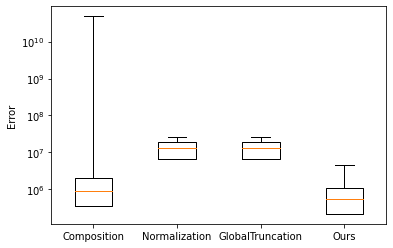

In [18]:
plt.ylabel('Error')
plt.boxplot([[abs(x) for x in errors_compo], [abs(x) for x in errors_norm], [abs(x) for x in errors_glb], [abs(x) for x in errors_trunc]], \
            labels=['Composition', 'Normalization', 'GlobalTruncation', 'Ours'], whis=(25,100), showfliers=False)
plt.yscale("symlog")
plt.show()